In [1]:
#from google.colab import drive

#drive.mount('/content/gdrive')

#import sys
#sys.path.append("/content/gdrive/MyDrive/QURIP-thompsonlab-amo/")

import numpy as np
import matplotlib.pyplot as plt
from ML_for_GreenImaging.PipelineStages import *
from tensorflow.keras import models, optimizers, layers, metrics

2023-07-08 14:26:30.172102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu'))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [3]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 20ms"
#model = models.load_model(path + "/model1.h5")

In [4]:
loader = Loader.Loader(100, 20, path, path + "/model1.h5")
stack, tot_loops, info = loader.run()

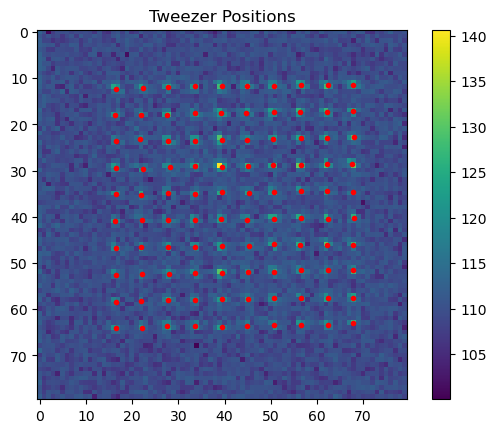

In [5]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

All brightness values for tweezer 20 are above the lower threshold!
No images for this tweezer can be labeled dark!


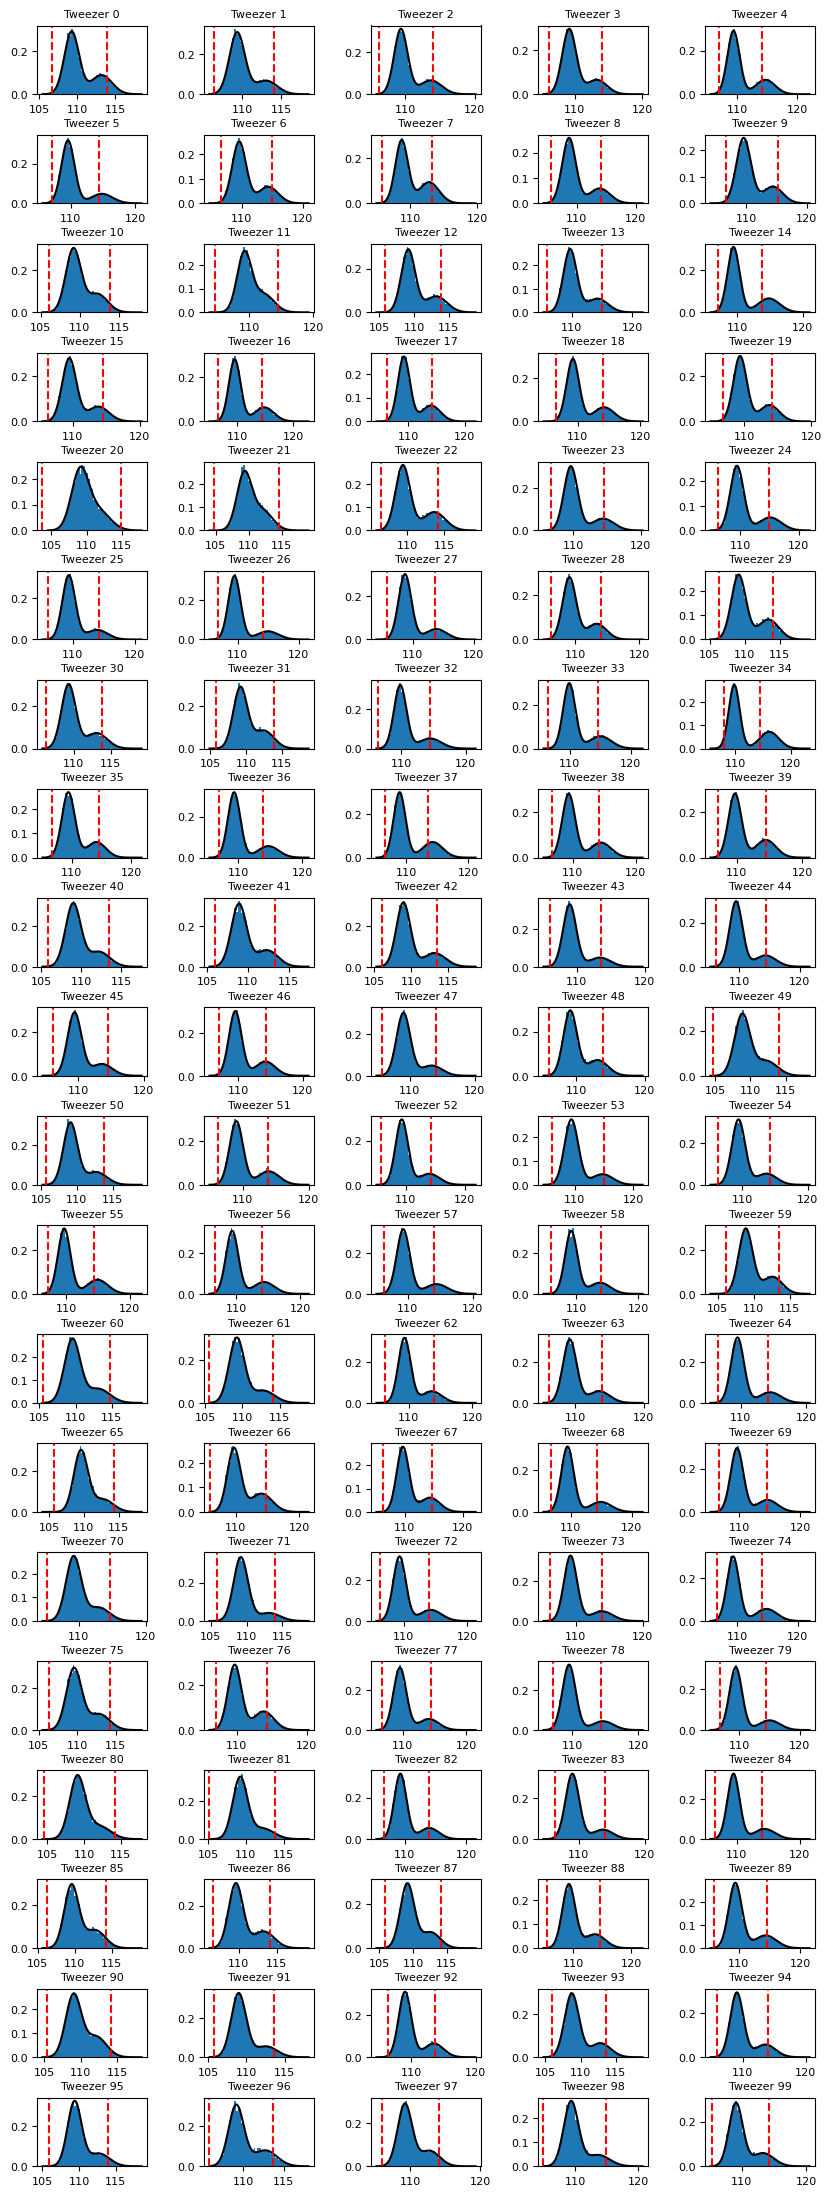

In [6]:
labeler = Labeler.Labeler(crops1x1, 100, tot_loops)
labels, info = labeler.run()

In [7]:
# Separate labels and crops for each site
crops3x3 = np.reshape(crops3x3, (100, *crops3x3.shape[1:]))
labels = np.transpose(np.array([np.absolute(labels - 1), labels]))
labels = np.reshape(labels, (100, -1, 2))
bad = np.isnan(labels)
keep = ~ bad
labels = [site_labels[site_keep[:, 0]] for site_labels, site_keep in zip(labels, keep)]
crops = [site_crops[site_keep[:, 0]] for site_crops, site_keep in zip(crops3x3, keep)]

In [8]:
# Randomly select 10% of each dataset for evaluation
testing = []
training = []
for tweezer_labels, tweezer_crops in zip(labels, crops):
    testing_indices = np.random.choice(tweezer_labels.shape[0], int(0.1 * tweezer_labels.shape[0]), replace=False)
    testing.append([tweezer_crops[testing_indices], tweezer_labels[testing_indices]])
    training.append([np.delete(tweezer_crops, testing_indices, axis=0), np.delete(tweezer_labels, testing_indices, axis=0)])

Text(0, 0.5, 'Samples')

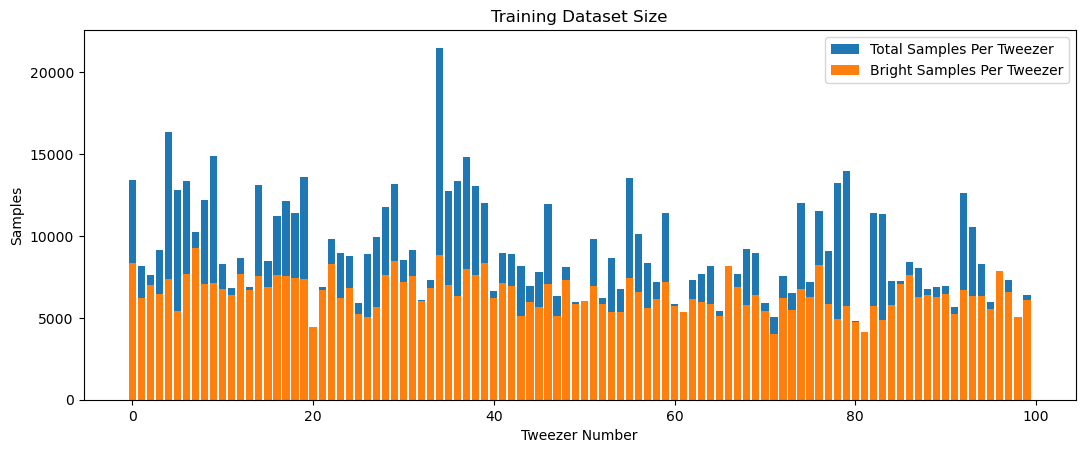

In [9]:
plt.figure(figsize=(12.8, 4.8))
plt.bar(np.arange(100), [len(training[i][0]) for i in range(100)], label="Total Samples Per Tweezer")
plt.bar(np.arange(100), [np.sum(training[i][1][:,1] == 1) for i in range(100)], label="Bright Samples Per Tweezer")
plt.legend()
plt.title("Training Dataset Size")
plt.xlabel("Tweezer Number")
plt.ylabel("Samples")

In [10]:
base_training_crops = np.concatenate([training[i][0] for i in range(100)])
base_training_labels = np.concatenate([training[i][1] for i in range(100)])
base_testing_crops = np.concatenate([testing[i][0] for i in range(100)])
base_testing_labels = np.concatenate([testing[i][1] for i in range(100)])

In [11]:
# Create base network to train for 4 epochs
model = architecture_1(crops3x3.shape[2:], [10, 10], [3, 3])
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy',
               metrics=[
                   'binary_accuracy',
                   metrics.TruePositives(),
                   metrics.TrueNegatives(),
                   metrics.FalsePositives(),
                   metrics.FalseNegatives()
                   ])

In [12]:
# Train base model
model.fit(base_training_crops, base_training_labels, epochs=4)

Epoch 1/4
28522/28522 [==============================] - 163s 6ms/step - loss: 0.0609 - binary_accuracy: 0.9833 - true_positives: 897403.0000 - true_negatives: 897452.0000 - false_positives: 15234.0000 - false_negatives: 15283.0000
Epoch 2/4
28522/28522 [==============================] - 162s 6ms/step - loss: 0.0344 - binary_accuracy: 0.9911 - true_positives: 904562.0000 - true_negatives: 904600.0000 - false_positives: 8086.0000 - false_negatives: 8124.0000
Epoch 3/4
28522/28522 [==============================] - 166s 6ms/step - loss: 0.0312 - binary_accuracy: 0.9918 - true_positives: 905201.0000 - true_negatives: 905238.0000 - false_positives: 7448.0000 - false_negatives: 7485.0000
Epoch 4/4
28522/28522 [==============================] - 127s 4ms/step - loss: 0.0291 - binary_accuracy: 0.9923 - true_positives: 905679.0000 - true_negatives: 905632.0000 - false_positives: 7054.0000 - false_negatives: 7007.0000


In [13]:
#trainer = ModelTrainer.ModelTrainer(model, (base_training_crops, base_training_labels), (base_testing_crops, base_testing_labels), np.reshape(crops3x3, (-1, *crops3x3.shape[2:])), 100, tot_loops, epochs=8)
#model, info = trainer.run()
#info = trainer.fidelity_analysis()
model.save(path + '/model1.h5')

In [14]:
# Create 100 NN's
networks = [models.load_model(path + '/model1.h5') for i in range(100)]
metrics = []

In [15]:
for i, tweezer_network in enumerate(networks):
    print(f"Tweezer {i}")
    tweezer_network.fit(*training[i], epochs=4)
    metrics.append(tweezer_network.evaluate(*testing[i]))

Tweezer 0
Epoch 1/4
419/419 [==============================] - 2s 4ms/step - loss: 0.0215 - binary_accuracy: 0.9954 - true_positives: 13333.0000 - true_negatives: 13336.0000 - false_positives: 60.0000 - false_negatives: 63.0000
Epoch 2/4
419/419 [==============================] - 2s 4ms/step - loss: 0.0193 - binary_accuracy: 0.9961 - true_positives: 13343.0000 - true_negatives: 13344.0000 - false_positives: 52.0000 - false_negatives: 53.0000
Epoch 3/4
419/419 [==============================] - 2s 4ms/step - loss: 0.0190 - binary_accuracy: 0.9962 - true_positives: 13346.0000 - true_negatives: 13345.0000 - false_positives: 51.0000 - false_negatives: 50.0000
Epoch 4/4
47/47 [==============================] - 0s 2ms/step - loss: 0.0303 - binary_accuracy: 0.9943 - true_positives: 1480.0000 - true_negatives: 1479.0000 - false_positives: 9.0000 - false_negatives: 8.0000
Tweezer 1
Epoch 1/4
255/255 [==============================] - 1s 4ms/step - loss: 0.0108 - binary_accuracy: 0.9963 - true_p

In [16]:
p_db = []
p_bd = []
for i, (network, crops) in enumerate(zip(networks, crops3x3)):
    print(f"Tweezer Number {i}")
    occ = np.argmax(network.predict(crops), axis=1)
    occ = np.reshape(occ, (tot_loops, -1))
    diff = np.diff(occ, axis=1)
    n_dark_to_bright = np.sum(diff == -1)
    n_dark = np.sum(occ[:,:-1] == 0)
    n_bright_to_dark = np.sum(diff == 1)
    n_bright = np.sum(occ[:,:-1] == 1)
    p_db.append(n_dark_to_bright / n_dark)
    p_bd.append(n_bright_to_dark / n_bright)

Tweezer Number 0
994/994 [==============================] - 1s 1ms/step
Tweezer Number 1
994/994 [==============================] - 1s 1ms/step
Tweezer Number 2
994/994 [==============================] - 1s 1ms/step
Tweezer Number 3
994/994 [==============================] - 1s 1ms/step
Tweezer Number 4
994/994 [==============================] - 1s 1ms/step
Tweezer Number 5
994/994 [==============================] - 1s 1ms/step
Tweezer Number 6
994/994 [==============================] - 1s 1ms/step
Tweezer Number 7
994/994 [==============================] - 1s 1ms/step
Tweezer Number 8
994/994 [==============================] - 1s 1ms/step
Tweezer Number 9
994/994 [==============================] - 1s 1ms/step
Tweezer Number 10
994/994 [==============================] - 1s 1ms/step
Tweezer Number 11
994/994 [==============================] - 1s 1ms/step
Tweezer Number 12
994/994 [==============================] - 1s 1ms/step
Tweezer Number 13
994/994 [==============================] - 

In [17]:
p_db = np.array(p_db)
p_bd = np.array(p_bd)

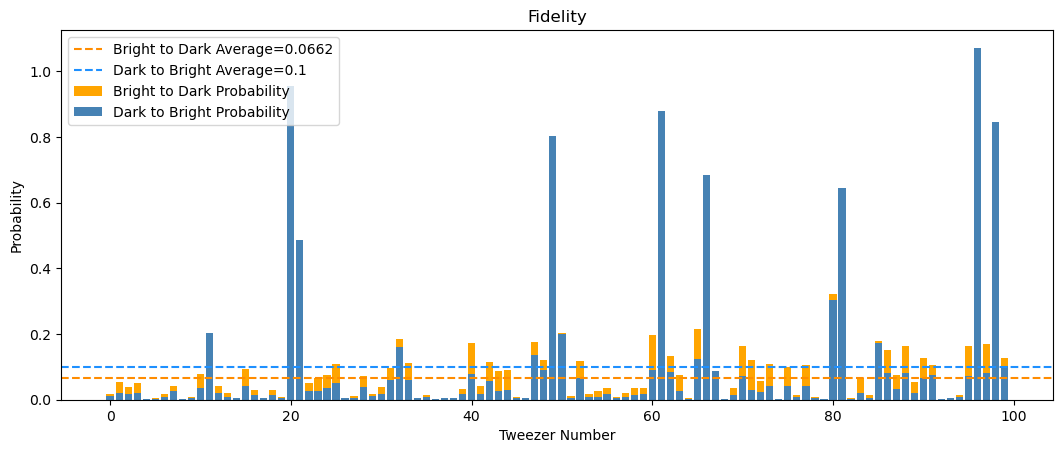

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize=(12.8, 4.8))
plt.bar(np.arange(100), p_bd, label=f'Bright to Dark Probability', color='orange')
plt.bar(np.arange(100), p_db, label=f'Dark to Bright Probability', color='steelblue')
plt.axhline(p_bd.mean(), label=f"Bright to Dark Average={np.mean(p_bd):.3}", color='darkorange', linestyle='--')
plt.axhline(p_db.mean(), label=f"Dark to Bright Average={np.mean(p_db):.3}", color='dodgerblue', linestyle='--')
plt.xlabel('Tweezer Number')
plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.title('Fidelity')
plt.show()
plt.savefig(path + "/figure2.png")

Text(0.5, 1.0, 'Bright Fraction Versus Transition Probability')

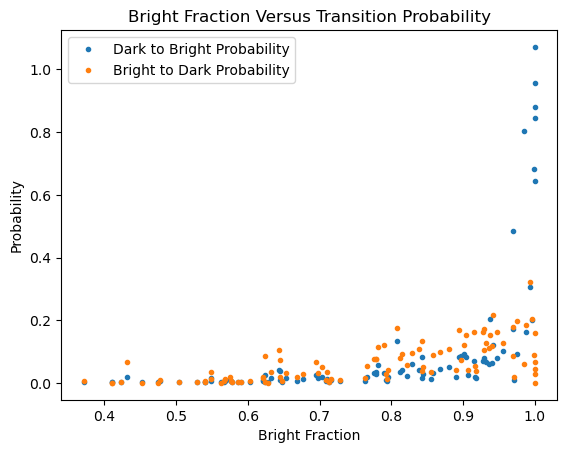

In [19]:
n_bright = np.array([np.sum(training[i][1][:,1] == 1) for i in range(100)])
tot = np.array([len(training[i][0]) for i in range(100)])
plt.plot(n_bright / tot, p_db, '.', label="Dark to Bright Probability")
plt.plot(n_bright / tot, p_bd, '.', label="Bright to Dark Probability")
plt.xlabel("Bright Fraction")
plt.ylabel("Probability")
plt.legend()
plt.title("Bright Fraction Versus Transition Probability")

In [20]:
tot_false_positive = np.sum([metrics[i][4] for i in range(100)])
tot_positives = np.sum([metrics[i][2] for i in range(100)]) + np.sum([metrics[i][4] for i in range(100)])
print(tot_false_positive / tot_positives)

0.003374211943920992


In [21]:
tot_false_negatives = np.sum([metrics[i][5] for i in range(100)])
tot_negatives = np.sum([metrics[i][3] for i in range(100)]) + np.sum([metrics[i][5] for i in range(100)])
print(tot_false_negatives / tot_negatives)

0.003423204790513678


In [22]:
tot_correct = np.sum([metrics[i][2] for i in range(100)]) + np.sum([metrics[i][3] for i in range(100)])
tot_wrong = np.sum([metrics[i][4] for i in range(100)]) + np.sum([metrics[i][5] for i in range(100)])

print(tot_correct / (tot_wrong + tot_correct))

0.9966012904244194


In [23]:
# Train base model
model.fit(base_training_crops, base_training_labels, epochs=2)
model.save(path + '/model1.h5')

Epoch 1/2
28522/28522 [==============================] - 102s 4ms/step - loss: 0.0275 - binary_accuracy: 0.9926 - true_positives: 905915.0000 - true_negatives: 905892.0000 - false_positives: 6794.0000 - false_negatives: 6771.0000
Epoch 2/2
28522/28522 [==============================] - 103s 4ms/step - loss: 0.0266 - binary_accuracy: 0.9928 - true_positives: 906080.0000 - true_negatives: 906113.0000 - false_positives: 6573.0000 - false_negatives: 6606.0000


In [24]:
# Create 100 NN's
networks = [models.load_model(path + '/model1.h5') for i in range(100)]
histories = []
metrics = []

In [25]:
for i, tweezer_network in enumerate(networks):
    print(f"Tweezer {i}")
    histories.append(tweezer_network.fit(*training[i], epochs=2))
    metrics.append(tweezer_network.evaluate(*testing[i]))

Tweezer 0
Epoch 1/2
419/419 [==============================] - 3s 5ms/step - loss: 0.0218 - binary_accuracy: 0.9951 - true_positives: 13330.0000 - true_negatives: 13332.0000 - false_positives: 64.0000 - false_negatives: 66.0000
Epoch 2/2
47/47 [==============================] - 0s 2ms/step - loss: 0.0235 - binary_accuracy: 0.9946 - true_positives: 1480.0000 - true_negatives: 1480.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Tweezer 1
Epoch 1/2
255/255 [==============================] - 1s 4ms/step - loss: 0.0100 - binary_accuracy: 0.9963 - true_positives: 8110.0000 - true_negatives: 8110.0000 - false_positives: 30.0000 - false_negatives: 30.0000
Epoch 2/2
29/29 [==============================] - 0s 2ms/step - loss: 0.0056 - binary_accuracy: 0.9994 - true_positives: 903.0000 - true_negatives: 904.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000  
Tweezer 2
Epoch 1/2
238/238 [==============================] - 1s 4ms/step - loss: 0.0046 - binary_accuracy: 0.9988 - 

In [26]:
p_db = []
p_bd = []
for i, (network, crops) in enumerate(zip(networks, crops3x3)):
    print(f"Tweezer Number {i}")
    occ = np.argmax(network.predict(crops), axis=1)
    occ = np.reshape(occ, (tot_loops, -1))
    diff = np.diff(occ, axis=1)
    n_dark_to_bright = np.sum(diff == -1)
    n_dark = np.sum(occ[:,:-1] == 0)
    n_bright_to_dark = np.sum(diff == 1)
    n_bright = np.sum(occ[:,:-1] == 1)
    p_db.append(n_dark_to_bright / n_dark)
    p_bd.append(n_bright_to_dark / n_bright)

Tweezer Number 0
994/994 [==============================] - 1s 1ms/step
Tweezer Number 1
994/994 [==============================] - 1s 1ms/step
Tweezer Number 2
994/994 [==============================] - 1s 1ms/step
Tweezer Number 3
994/994 [==============================] - 1s 1ms/step
Tweezer Number 4
994/994 [==============================] - 1s 1ms/step
Tweezer Number 5
994/994 [==============================] - 1s 1ms/step
Tweezer Number 6
994/994 [==============================] - 1s 1ms/step
Tweezer Number 7
994/994 [==============================] - 1s 1ms/step
Tweezer Number 8
994/994 [==============================] - 1s 1ms/step
Tweezer Number 9
994/994 [==============================] - 1s 1ms/step
Tweezer Number 10
994/994 [==============================] - 1s 1ms/step
Tweezer Number 11
994/994 [==============================] - 1s 1ms/step
Tweezer Number 12
994/994 [==============================] - 1s 1ms/step
Tweezer Number 13
994/994 [==============================] - 

In [27]:
p_db = np.array(p_db)
p_bd = np.array(p_bd)

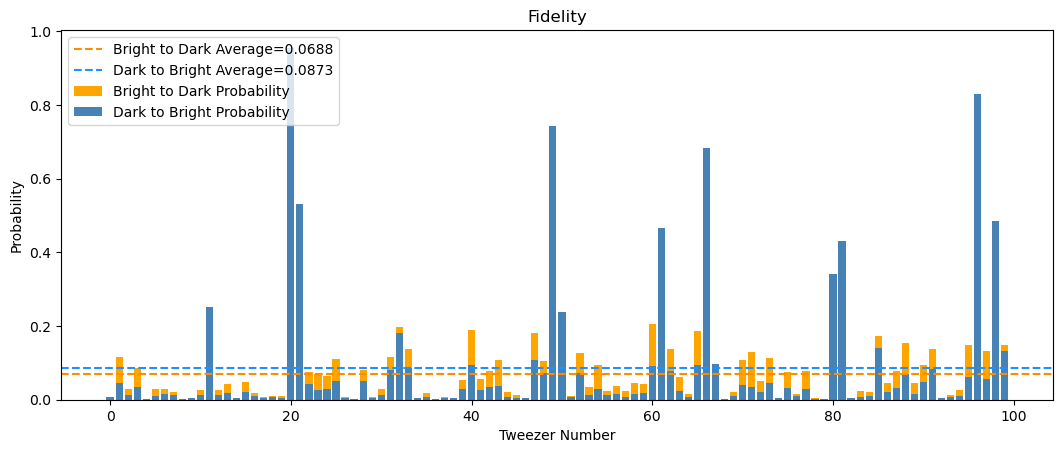

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(12.8, 4.8))
plt.bar(np.arange(100), p_bd, label=f'Bright to Dark Probability', color='orange')
plt.bar(np.arange(100), p_db, label=f'Dark to Bright Probability', color='steelblue')
plt.axhline(p_bd.mean(), label=f"Bright to Dark Average={np.mean(p_bd):.3}", color='darkorange', linestyle='--')
plt.axhline(p_db.mean(), label=f"Dark to Bright Average={np.mean(p_db):.3}", color='dodgerblue', linestyle='--')
plt.xlabel('Tweezer Number')
plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.title('Fidelity')
plt.show()
plt.savefig(path + "/figure2.png")

Text(0.5, 1.0, 'Bright Fraction Versus Transition Probability')

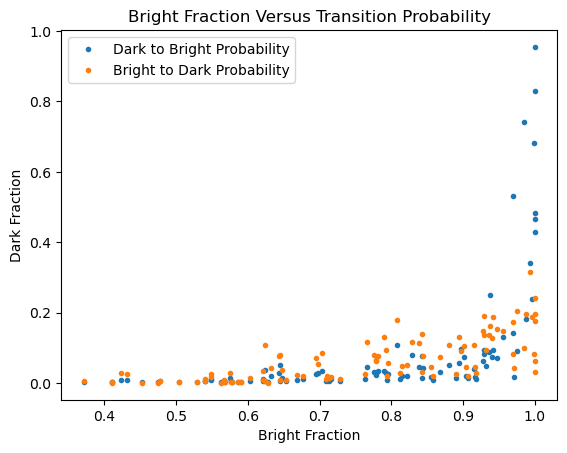

In [29]:
n_bright = np.array([np.sum(training[i][1][:,1] == 1) for i in range(100)])
tot = np.array([len(training[i][0]) for i in range(100)])
plt.plot(n_bright / tot, p_db, '.', label="Dark to Bright Probability")
plt.plot(n_bright / tot, p_bd, '.', label="Bright to Dark Probability")
plt.xlabel("Bright Fraction")
plt.ylabel("Dark Fraction")
plt.legend()
plt.title("Bright Fraction Versus Transition Probability")

In [30]:
tot_false_positive = np.sum([metrics[i][4] for i in range(100)])
tot_positives = np.sum([metrics[i][2] for i in range(100)]) + np.sum([metrics[i][4] for i in range(100)])
print(tot_false_positive / tot_positives)

0.0033740122135295916


In [31]:
tot_false_negatives = np.sum([metrics[i][5] for i in range(100)])
tot_negatives = np.sum([metrics[i][3] for i in range(100)]) + np.sum([metrics[i][5] for i in range(100)])
print(tot_false_negatives / tot_negatives)

0.0033642130602499977


In [32]:
tot_correct = np.sum([metrics[i][2] for i in range(100)]) + np.sum([metrics[i][3] for i in range(100)])
tot_wrong = np.sum([metrics[i][4] for i in range(100)]) + np.sum([metrics[i][5] for i in range(100)])

print(tot_correct / (tot_wrong + tot_correct))

0.9966308873147728


Epoch 1/2
28522/28522 [==============================] - 135s 5ms/step - loss: 0.0258 - binary_accuracy: 0.9929 - true_positives: 906244.0000 - true_negatives: 906198.0000 - false_positives: 6488.0000 - false_negatives: 6442.0000
Epoch 2/2
99313/99313 [==============================] - 108s 1ms/step
(100, 140, 227)


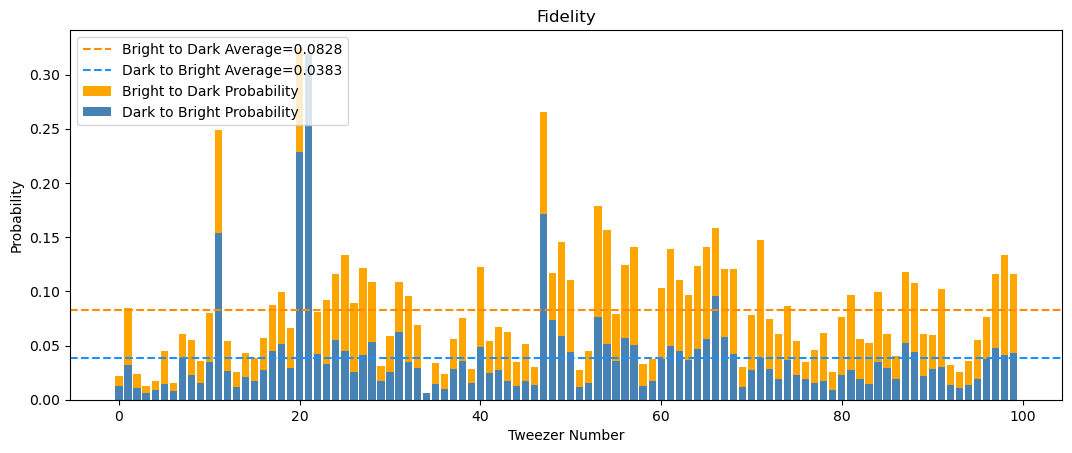

In [33]:
trainer = ModelTrainer.ModelTrainer(model, (base_training_crops, base_training_labels), (base_testing_crops, base_testing_labels), np.reshape(crops3x3, (-1, *crops3x3.shape[2:])), 100, tot_loops, epochs=2)
model, info = trainer.run()

Text(0.5, 1.0, 'Bright Fraction Versus Transition Probability')

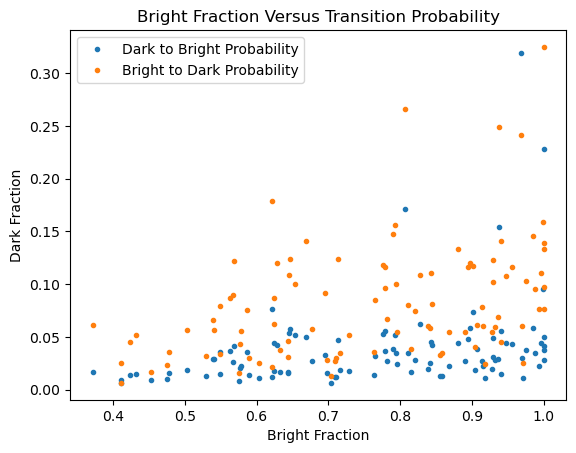

In [34]:
n_bright = np.array([np.sum(training[i][1][:,1] == 1) for i in range(100)])
tot = np.array([len(training[i][0]) for i in range(100)])
plt.plot(n_bright / tot, info["Average Dark to Bright Probability"], '.', label="Dark to Bright Probability")
plt.plot(n_bright / tot, info["Average Bright to Dark Probabiblity"], '.', label="Bright to Dark Probability")
plt.xlabel("Bright Fraction")
plt.ylabel("Dark Fraction")
plt.legend()
plt.title("Bright Fraction Versus Transition Probability")